# Bootstrap Calibrations

In [1]:
%matplotlib inline

In [9]:
# imports
try:
    import seaborn as sns; sns.set(context="notebook",font_scale=2)
except:
    pass

from desispec import bootcalib as desiboot
from desiutil import funcfits as dufits
from astropy.io import fits
from astropy.stats import sigma_clip

import numpy as np
from astropy.modeling import models, fitting

## Find peaks

In [72]:
# Read flat
flat_hdu = fits.open('/Users/xavier/DESI/Wavelengths/pix-b0-00000001.fits')
header = flat_hdu[0].header
flat = flat_hdu[0].data

In [4]:
reload(desiboot)
xpk, ypos, cut = desiboot.find_fiber_peaks(flat)#,debug=True)

Found 500 fibers
Found 20 bundles


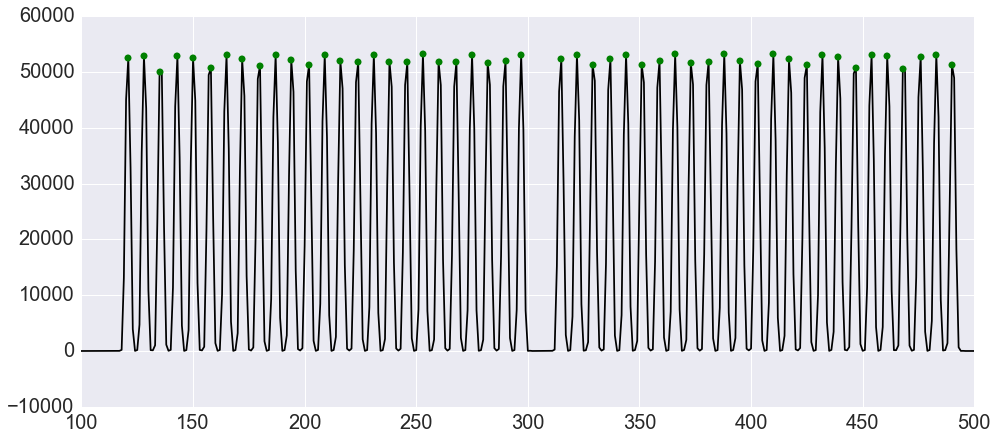

In [5]:
# Check
plt.clf()
plt.figure(figsize=(16,7))
xplt = np.arange(cut.size)
plt.plot(xplt,cut, 'k-')
plt.plot(xpk, cut[xpk],'go')
plt.xlim(100,500)
plt.show()
plt.close()

## Trace the flat spectra

### Crude estimate (flux weighted centroid)

In [6]:
reload(desiboot)
xset, xerr = desiboot.trace_crude_init(flat,xpk[0:50],ypos)

### Polynomial fits (test)

In [10]:
yval = np.arange(4096)
ii=4
xval = xset[:,ii]
gdval = xerr[:,ii] < 999.
dfit0 = dufits.func_fit(yval[gdval],xval[gdval],'legendre',6)

In [12]:
fitv = dufits.func_val(yval,dfit0)

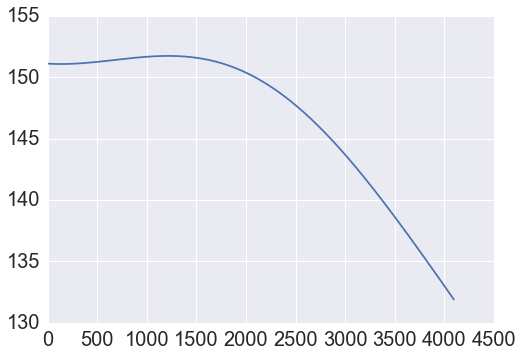

In [13]:
# Fit
xdb.xplot(yval,fitv, xtwo=yval,ytwo=xset[:,ii],mtwo='+')

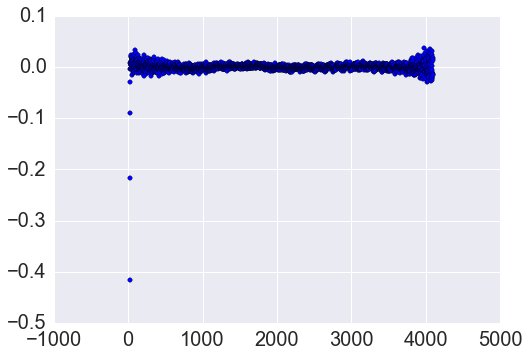

In [14]:
# Residuals
xdb.xplot(yval[gdval],fitv[gdval]-xval[gdval], scatter=True)

### Polynomial fits (True)

In [15]:
reload(desiboot)
xfit, fdicts = desiboot.fit_traces(xset,xerr)#[:,0:5],xerr[:,0:5])

### QA

In [16]:
reload(desiboot)
desiboot.fiber_trace_qa(flat,xfit)

Writing fiber_trace_qa.pdf QA for fiber trace


## PSF

### Sigma for each fiber (initial guess)

In [17]:
reload(desiboot)
gauss = desiboot.fiber_gauss(flat,xfit,xerr)#,verbose=True)#,debug=True)

/Users/xavier/DESI/desispec/py/desispec/bootcalib.py:347: UserWarning: fiber_gauss uses astropy.modeling.  Consider an alternative
  warnings.warn("fiber_gauss uses astropy.modeling.  Consider an alternative")


### Fit a 2nd Order Polynomial

In [18]:
fiber = np.arange(gauss.size)
gfdict,mask = dufits.iter_fit(fiber, gauss, 'polynomial', 2)

In [19]:
gfdict

{'coeff': array([  1.13884605e+00,  -6.21915177e-03,  -5.39514007e-05]),
 'func': 'polynomial',
 'order': 2,
 'xmax': 49,
 'xmin': 0}

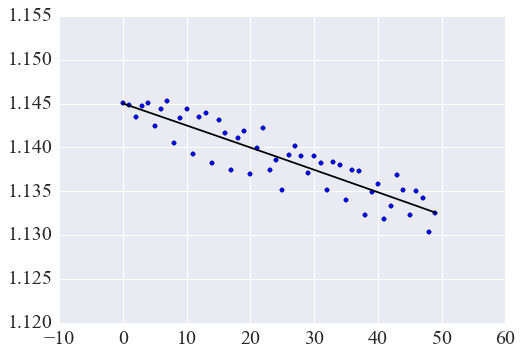

In [20]:
plt.clf()
plt.scatter(fiber,gauss)
plt.plot(fiber, dufits.func_val(fiber,gfdict),'k-')
#plt.xlim(100,500)
plt.show()
plt.close()

## Extract Arc (one fiber at a time)

### Load Image

In [21]:
arc = fits.open('/Users/xavier/DESI/Wavelengths/pix-b0-00000000.fits')[0].data

### Extract

In [22]:
reload(desiboot)
all_spec = desiboot.extract_sngfibers_gaussianpsf(arc,xfit,gauss)
all_spec.shape

0
10
20
30
40


(4096, 50)

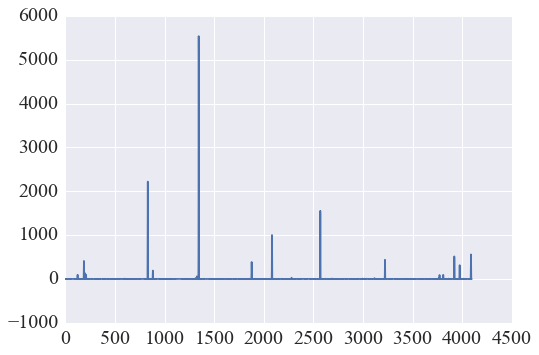

In [23]:
xdb.xplot(np.arange(all_spec[:,0].size), all_spec[:,0])#, sv_aspec[1], sv_aspec[2])

## Wavelength info

In [24]:
# Dispersion
import desimodel.io

In [25]:
desi_psf = desimodel.io.load_psf('b')

In [26]:
desi_psf.wdisp(0,4500.) # fiber, wavelength

0.62349114076195089

In [27]:
wave0 = desi_psf.wavelength(0,np.arange(desi_psf.npix_y))

In [28]:
np.max(wave0)

5948.6835574399602

In [29]:
med_bdisp = np.median(desi_psf.wdisp(0,wave0))
med_bdisp

0.63191076246357147

In [30]:
np.median(np.abs(wave0-np.roll(wave0,1)))

0.5920365191327619

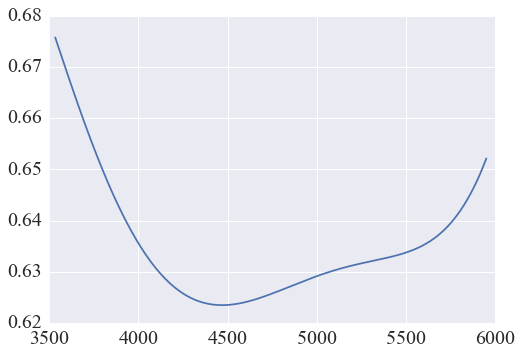

In [31]:
xdb.xplot(wave0,desi_psf.wdisp(0,wave0))

In [32]:
desi_psf.npix_x, desi_psf.npix_y

(4096, 4096)

In [34]:
poly_fit = dufits.func_fit(wave0,np.arange(desi_psf.npix_y), 'polynomial',2,xmin=0.,xmax=1.)
poly_fit

{'coeff': array([ -5.05608278e+03,   6.38522295e-01,   1.09530252e-05]),
 'func': 'polynomial',
 'order': 2,
 'xmax': 1.0,
 'xmin': 0.0}

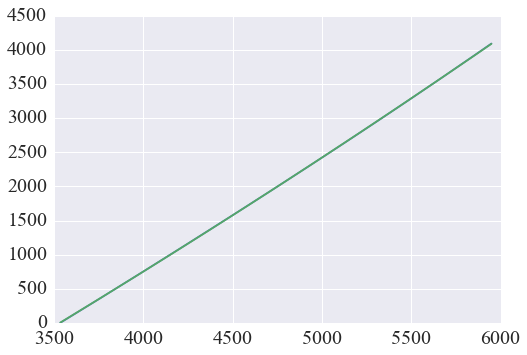

In [35]:
xdb.xplot(wave0, np.arange(desi_psf.npix_y),dufits.func_val(wave0,poly_fit))

## Find Lines

In [68]:
reload(desiboot)
spec = all_spec[:,0]
pixpk = desiboot.find_arc_lines(spec)

In [69]:
len(pixpk)

19

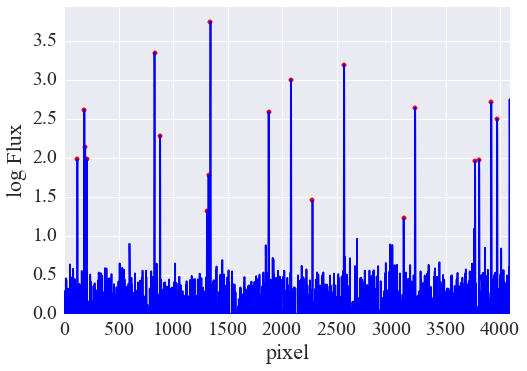

In [70]:
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(pixpk,yspec[np.round(pixpk).astype(int)],color='red')
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

## Identify Arc Lines

### Init

In [76]:
camera = header['CAMERA']
print(camera)

b0


### Load line list 

In [77]:
reload(desiboot)
#llist = pypit_alines.load_arcline_list(None,None,['CdI','ArI','NeI','HgI'],wvmnx=aparm['wvmnx'])
llist = desiboot.load_arcline_list(camera)#['CdI','ArI','HgI','NeI'])

INFO:bootcalib.py:419:load_arcline_list: Rejecting select CdI lines


INFO:DESI:Rejecting select CdI lines


INFO:bootcalib.py:419:load_arcline_list: Rejecting select HgI lines


INFO:DESI:Rejecting select HgI lines


INFO:bootcalib.py:419:load_arcline_list: Rejecting select NeI lines


INFO:DESI:Rejecting select NeI lines


### Grab lines

In [44]:
reload(desiboot)
dlamb, wmark, gd_lines = desiboot.load_gdarc_lines(camera)
dlamb, wmark, gd_lines

(0.589,
 4358.34,
 array([ 3610.51 ,  3650.157,  4046.57 ,  4077.84 ,  4358.34 ,  4678.15 ,
         4799.91 ,  5085.822,  5460.75 ,  5769.598,  5881.895,  5944.834]))

### Match a set of 5 gd_lines to detected lines

In [45]:
reload(desiboot)
id_dict = desiboot.id_arc_lines(pixpk,gd_lines,dlamb,wmark)

In [46]:
id_dict

{u'dlamb': 0.589,
 u'first_id_idx': [4, 5, 8, 9, 10],
 u'first_id_pix': array([  829.72229862,   880.90758168,  1343.18202243,  1876.81683412,
         2082.08519489]),
 u'first_id_wave': array([ 4046.57,  4077.84,  4358.34,  4678.15,  4799.91]),
 u'fit': {'coeff': array([ -5.20987817e+03,   6.74857691e-01,   8.83540824e-06]),
  'func': u'polynomial',
  'order': 2,
  'xmax': 1.0,
  'xmin': 0.0},
 'guess': 8,
 u'icen': 4,
 'im1': 5,
 'im2': 4,
 'ip1': 9,
 'ip2': 10,
 'rms': 0.052928404679943641,
 u'wmark': 4358.34}

/Users/xavier/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


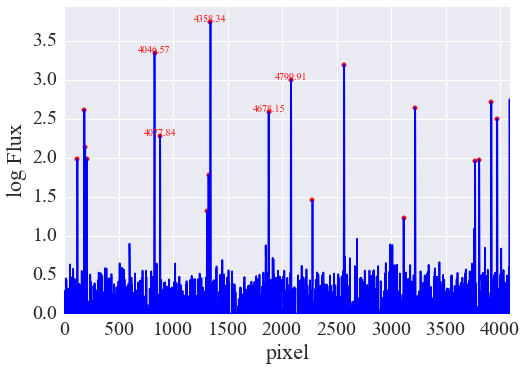

In [47]:
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,pixpk in enumerate(id_dict['first_id_pix']):
    plt.text(pixpk, yspec[np.round(pixpk)], '{:g}'.format(id_dict['first_id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

### Idenfity additional selected lines

In [50]:
reload(desiboot)
desiboot.add_gdarc_lines(id_dict, pixpk, gd_lines)

rms = 0.211782


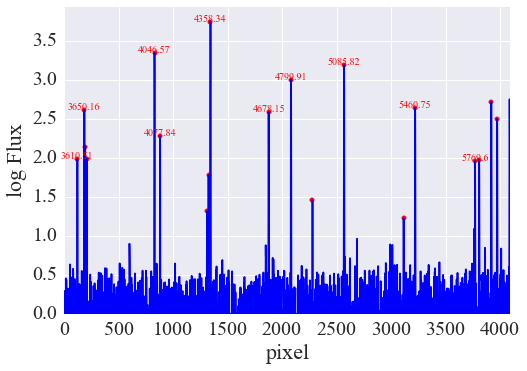

In [51]:
# IDs
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,pixpk in enumerate(id_dict['id_pix']):
    plt.text(pixpk, yspec[int(np.round(pixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

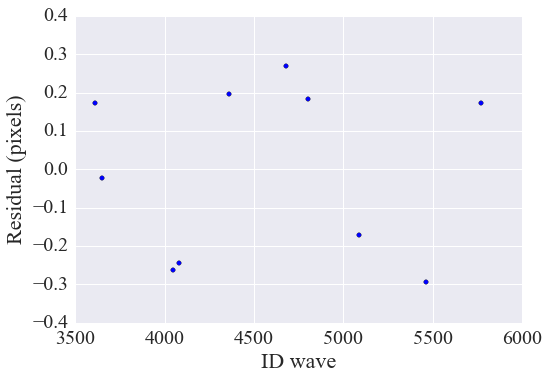

In [53]:
# Residuals
plt.clf()
# Fit
yfit = dufits.func_val(np.array(id_dict['id_wave']),id_dict['fit'])
# IDs
plt.scatter(id_dict['id_wave'], np.array(id_dict['id_pix'])-yfit)
#
plt.xlabel('ID wave')
plt.ylabel('Residual (pixels)')
plt.show()
plt.close()

### Identify as many others as possible

In [54]:
reload(desiboot)
desiboot.id_remainder(id_dict, pixpk, llist)

Matched 193.636 to 3654.84
Matched 207.156 to 3663.28
Matched 3808.57 to 5790.67
Matched 3920.21 to 5852.49
Matched 3973.63 to 5881.9


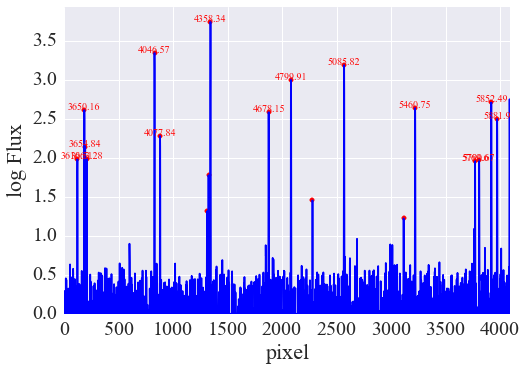

In [55]:
# IDs
plt.clf()
yspec = np.log10(np.maximum(spec,1))
xplt = np.arange(spec.size)
plt.plot(xplt,yspec,'b-')
plt.scatter(xpk,yspec[np.round(xpk).astype(int)],color='red')
# Guesses
for jj,pixpk in enumerate(id_dict['id_pix']):
    plt.text(pixpk, yspec[int(np.round(pixpk))], '{:g}'.format(id_dict['id_wave'][jj]),
         ha='center',color='red')
#
plt.ylim(0.,np.max(yspec)*1.05)
plt.xlim(0,spec.size)
plt.xlabel('pixel')
plt.ylabel('log Flux')
plt.show()
plt.close()

In [57]:
# Fit with rejection
final_fit,mask = dufits.iter_fit(np.array(id_dict['id_wave']),np.array(id_dict['id_pix']),'polynomial',3,xmin=0.,xmax=1.)

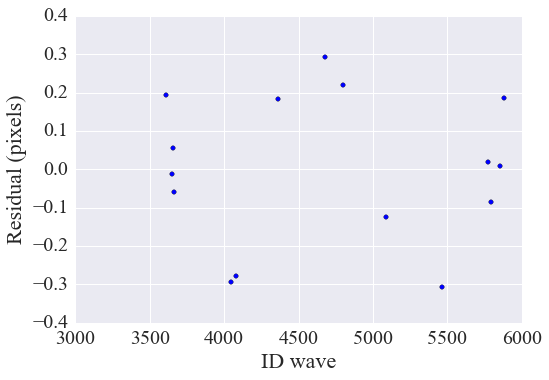

In [59]:
# Plot residuals
plt.clf()
# Fit
yfit = dufits.func_val(np.array(id_dict['id_wave']),final_fit)
# IDs
plt.scatter(id_dict['id_wave'], np.array(id_dict['id_pix'])-yfit)
#
plt.xlabel('ID wave')
plt.ylabel('Residual (pixels)')
plt.show()
plt.close()

## Generate DESI PSF output